In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Multiple Layer, Tanh, Multiclass Classification
### Attempted over-fit

In [2]:
# Lets import some libraries
import numpy as np

import os

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl

import seaborn as sns

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            ConfusionMatrixDisplay)

from tqdm import tqdm # extra to show progres bar

%matplotlib inline

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('./')

# set location of inputs for this module
moduleDir = './'
# set location of output files
outDir = os.path.join('./')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.coolwarm
plt.rcParams.update(params);
plt.set_cmap(CMAP);

TEST_SIZE = 0.2 # Test size
EPOCHS = 50000  # number of epochs
ALPHA = 0.1  # learning rate

NUM_SAMPLES = 1280
NOISE = 0.2

<Figure size 1500x600 with 0 Axes>

## Generate Data Set
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.

In [4]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, 
                           noise=NOISE, random_state=RANDOM_STATE)

print (X.shape, y.shape)

(1280, 2) (1280,)


In [5]:
y = pd.get_dummies(y).to_numpy()
y.shape

(1280, 2)

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                   random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1024, 2), (256, 2), (1024, 2), (256, 2))

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Forward Propagation

In [8]:
# Define function Softmax

def fn_softmax(z):
    
    exp_sc = np.exp(z)
    
    return exp_sc /np.sum(exp_sc, axis = 1, keepdims = True)

### Define function tanh

In [9]:
def fn_tanh(x):
    return np.tanh(x)

def fn_tanh_prime(x):
    return 1.0- np.tanh(x)**2


**Unit Test** : Its advisable to test the function.

In [10]:
fn_softmax(np.array([[3., 4, 5.]]))

array([[0.09003057, 0.24472847, 0.66524096]])

In [11]:
fn_tanh(0.5) == np.tanh(0.5)

True

In [12]:
fn_tanh_prime(0.5)

0.7864477329659274

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid/softmax output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$

### In case of Binary Classification:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -y_i.log\hat{y_i}
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}y_i.log\hat{y}_i
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [13]:
### Code Loss function

def calculate_loss(model, X, y):
    
    m = X.shape[0] # number of training examples

    ## Extract Weights
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    W4 = model['W4']
    W5 = model['W5']
    
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    b4 = model['b4']
    b5 = model['b5']

    ### Forward propagation
    # Layer 1
    z1 = X.dot(W1) + b1 # Aggregation fn
    a1 = fn_tanh(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation fn
    a2 = fn_tanh(z2) # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation fn
    a3 = fn_tanh(z3) # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation fn
    a4 = fn_tanh(z4) # Activation

    #----------------
    # Layer output
    #---------------
    z5 = a4.dot(W5) + b5  # Aggregation
    a5 = fn_softmax(z5) # Activation

    data_loss = -(y * np.log(a5) + (1 - y)*np.log( 1 - a5 ) ).sum()
    
    return 1./m * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation for supervised learning.

In [14]:
def predict(model, X):
    
    m = X.shape[0] # number of training examples

    ## Extract Weights
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    W4 = model['W4']
    W5 = model['W5']
    
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    b4 = model['b4']
    b5 = model['b5']

    ### Forward propagation
    # Layer 1
    z1 = X.dot(W1) + b1 # Aggregation fn
    a1 = fn_tanh(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation fn
    a2 = fn_tanh(z2) # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation fn
    a3 = fn_tanh(z3) # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation fn
    a4 = fn_tanh(z4) # Activation

    #----------------
    # Layer output
    #---------------
    z5 = a4.dot(W5) + b5  # Aggregation
    a5 = fn_softmax(z5) # Activation
    
    return a5

## For a single row of data x,

<img src='../../images/dnn_nb_s04_fig3.png' style='width: 800px;'/>

<img src='../../images/dnn_nb_s06_fig3.png' style='width: 800px' alt = 'dnn_nb_s06_fig3.png'/>

## Forward Propogation

<img src='../../images/dnn_nb_s06_fig4.png' style='width: 800px' alt = 'dnn_nb_s06_fig4.png'/>
<br>
                                                               
$
\begin{aligned}
z^{[l]} & = a^{[l-1]} . W^{[l]} + b^{[l]}\\
a^{[l]} & = \text{g}(z^{[l]})\text{ for hidden layers} \\
a^{[l]} & = \mathrm{softmax}(z^{[l]})\text{ for output layer}  \\
\end{aligned}
$

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Notes:

We have transposed a few matrices in above calculations such as $a^{[1]}$, $W^{[2]}$ and X. A review of shapes of matrices will reveal that this adjustment is needed to have consistent sizes. e.g.

- Shape of $a^{[1]}$ and $\partial{z}^{[2]}$ are ( m, 4) and ( m, 1 ) respectively. Expected shape of $\partial{W^{[2]}}$ is ( 4, 1 ) which is same as that of $W^{[2]}$.
- In equation $\partial{z^{[1]}}  = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)$ shape of $z^{[2]}$,  $W^{[2]}$ and $a^{[1]}$ are (m,1), (4,1) and (m,4). For element wise multiplication, expected shape of dot product of is $z^{[2]}$ and $W^{[2]}$ is ( m, 4 ).
- Lastly, shape of $\partial{W^{[1]}}$ is (2,4) and that of X and $\partial{z^{[1]}}$ are ( m, 2 ) and ( m, 4 ).

## Build Model

In [15]:
def build_model(nn_layer, X, y, alpha = ALPHA, epochs=EPOCHS):
    
    W1 = np.random.rand(X.shape[1], nn_layer[0]) / np.sqrt(nn_layer[0])
    W2 = np.random.rand(nn_layer[0], nn_layer[1]) / np.sqrt(nn_layer[1])
    W3 = np.random.rand(nn_layer[1], nn_layer[2]) / np.sqrt(nn_layer[2])
    W4 = np.random.rand(nn_layer[2], nn_layer[3]) / np.sqrt(nn_layer[3])
    W5 = np.random.rand(nn_layer[3], nn_layer[4]) / np.sqrt(nn_layer[4])
 
    b1 = np.zeros((1, nn_layer[0]))
    b2 = np.zeros((1, nn_layer[1]))
    b3 = np.zeros((1, nn_layer[2]))
    b4 = np.zeros((1, nn_layer[3]))
    b5 = np.zeros((1, nn_layer[4]))
    
    m  = X.shape[0] # number of training example
    
    loss, e_list = [], []
    
    for epoch in tqdm(range(epochs)):
        
        ### Forward propagation
        # Layer 1
        z1 = X.dot(W1) + b1 # Aggregation fn
        a1 = fn_tanh(z1) # Activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2 # Aggregation fn
        a2 = fn_tanh(z2) # Activation
        
        # Layer 3
        z3 = a2.dot(W3) + b3 # Aggregation fn
        a3 = fn_tanh(z3) # Activation
        
        # Layer 4
        z4 = a3.dot(W4) + b4 # Aggregation fn
        a4 = fn_tanh(z4) # Activation
    
        #----------------
        # Layer output
        #---------------
        z5 = a4.dot(W5) + b5  # Aggregation
        a5 = fn_softmax(z5) # Activation
        
        ### Back propagation
        # Layer output
        assert (a5.shape == y.shape), f'Shape a5: {a5.shape} and y : {y.shape}'
        dz5 = a5 - y
        dW5 = (a4.T).dot(dz5)
        assert (W5.shape == dW5.shape), f'Shape W5: {W5.shape} and dW5 : {dW5.shape}'
        db5 = np.sum(dz5, axis=0, keepdims=True) # db5 is vertical sum of dz5
        assert (b5.shape == db5.shape), f'Shape b5: {b5.shape} and db5 : {db5.shape}'
        da4 = dz5.dot(W5.T)

        
        # Layer 4
        dz4 = da4 * fn_tanh_prime(a4)        
        dW4 = (a3.T).dot(dz4)
        assert (W4.shape == dW4.shape), f'Shape W4: {W4.shape} and dW4 : {dW4.shape}'
        db4 = np.sum(dz4, axis = 0, keepdims=True)
        assert (b4.shape == db4.shape), f'Shape b4: {b4.shape} and db4 : {db4.shape}'
        da3 = dz4.dot(W4.T)
       
        # Layer 3
        dz3 = da3 * fn_tanh_prime(a3)        
        dW3 = (a2.T).dot(dz3)
        assert (W3.shape == dW3.shape), f'Shape W3: {W3.shape} and dW3 : {dW3.shape}'
        db3 = np.sum(dz3, axis = 0, keepdims=True)
        assert (b3.shape == db3.shape), f'Shape b3: {b3.shape} and db3 : {db3.shape}'
        da2 = dz3.dot(W3.T)
        
        #Layer 2
        dz2 = da2 * fn_tanh_prime(a2)        
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), f'Shape W2: {W2.shape} and dW2 : {dW2.shape}'
        db2 = np.sum(dz2, axis = 0, keepdims=True)
        assert (b2.shape == db2.shape), f'Shape b2: {b2.shape} and db2 : {db2.shape}'
        da1 = dz2.dot(W2.T)

        
        # Layer 1
        dz1 = da1 * fn_tanh_prime(z1) # element wise multiplication
        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), f'Shape W1: {W1.shape} and dW1 : {dW1.shape}'
        db1 = np.sum(dz1, axis = 0, keepdims=True)
        assert (b1.shape == db1.shape), f'Shape b1: {b1.shape} and db1 : {db1.shape}'
        
        # update weights by small amount
        W1 = W1 - alpha * dW1 / m
        W2 = W2 - alpha * dW2 / m
        W3 = W3 - alpha * dW3 / m
        W4 = W4 - alpha * dW4 / m
        W5 = W5 - alpha * dW5 / m
        
        b1 = b1 - alpha * db1 / m
        b2 = b2 - alpha * db2 / m
        b3 = b3 - alpha * db3 / m
        b4 = b4 - alpha * db4 / m
        b5 = b5 - alpha * db5 / m
        
        model = {'W1': W1, 'W2': W2, 'W3': W3, 'W4': W4, 'W5': W5, 
                 'b1': b1,'b2': b2, 'b3': b3,'b4': b4, 'b5': b5}

        # Calculate loss
        curr_loss = calculate_loss(model, X, y)

        loss.append(curr_loss)
        e_list.append(epoch)

    hist['loss'] = loss
    hist['epoch'] = e_list
    
    return model
       

In [16]:
hist = {}

In [17]:
num_layers = [50, 50, 40, 30, 2]

# Unit testing
#model = build_model(num_layers, X_train, y_train, epochs=1)


model = build_model(num_layers, X_train, y_train)

100%|██████████| 50000/50000 [15:49<00:00, 52.66it/s]


In [18]:
pd.DataFrame(hist).head()

,loss,epoch
0,1.394826,0
1,1.347637,1
2,1.321136,2
3,1.296609,3
4,1.261065,4


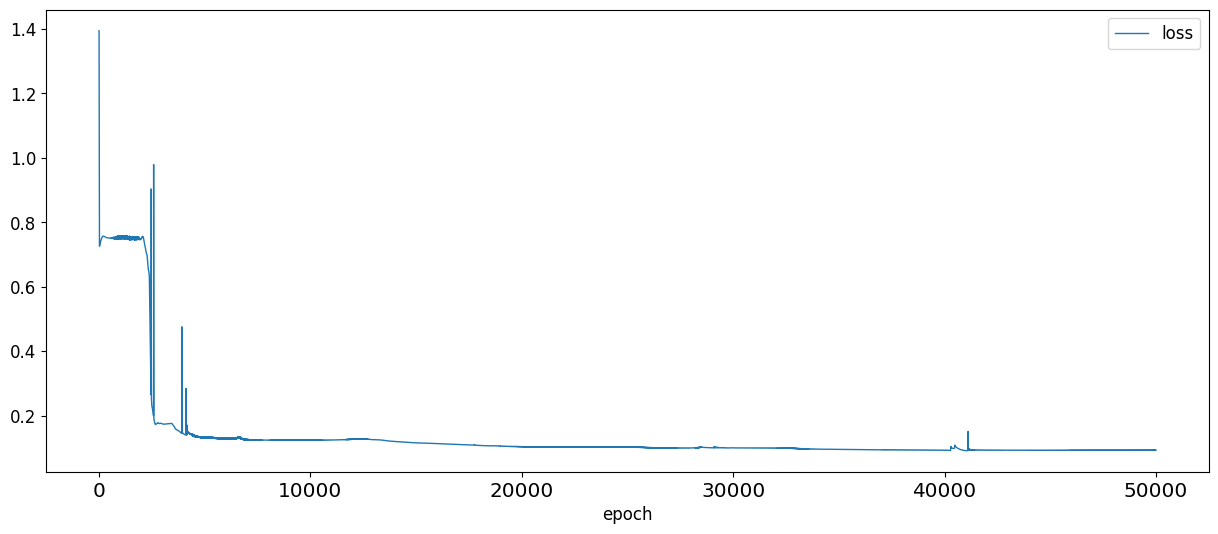

In [19]:
pd.DataFrame(hist).plot(x = 'epoch', y = 'loss');

## Predictions

### Train Set

In [20]:
y_pred = predict (model, X_train)


accuracy_score(y_train.argmax(axis = 1), y_pred.argmax(axis = 1))

0.9755859375

### Test Set

In [21]:
y_pred = predict (model, X_test)
    
accuracy_score(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))

0.9609375

In [22]:
cm = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
cm

array([[116,   2],
       [  8, 130]], dtype=int64)

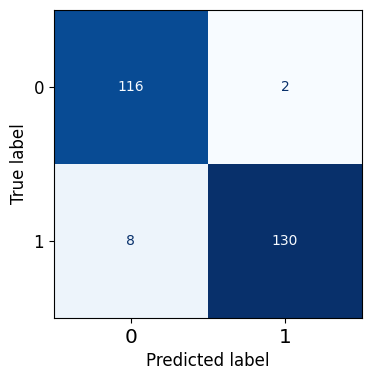

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();

In [24]:
def fn_plot_decision_boundary(pred_func, X, y):
    
    fig, ax = plt.subplots(figsize= (15, 12))
    
    dm = 0.01
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    y_p = pred_func(np.c_[xx.ravel(), yy.ravel()])

    Z= y_p.argmax(axis = 1)
    
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y.argmax(axis = 1),
                                  s=30, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

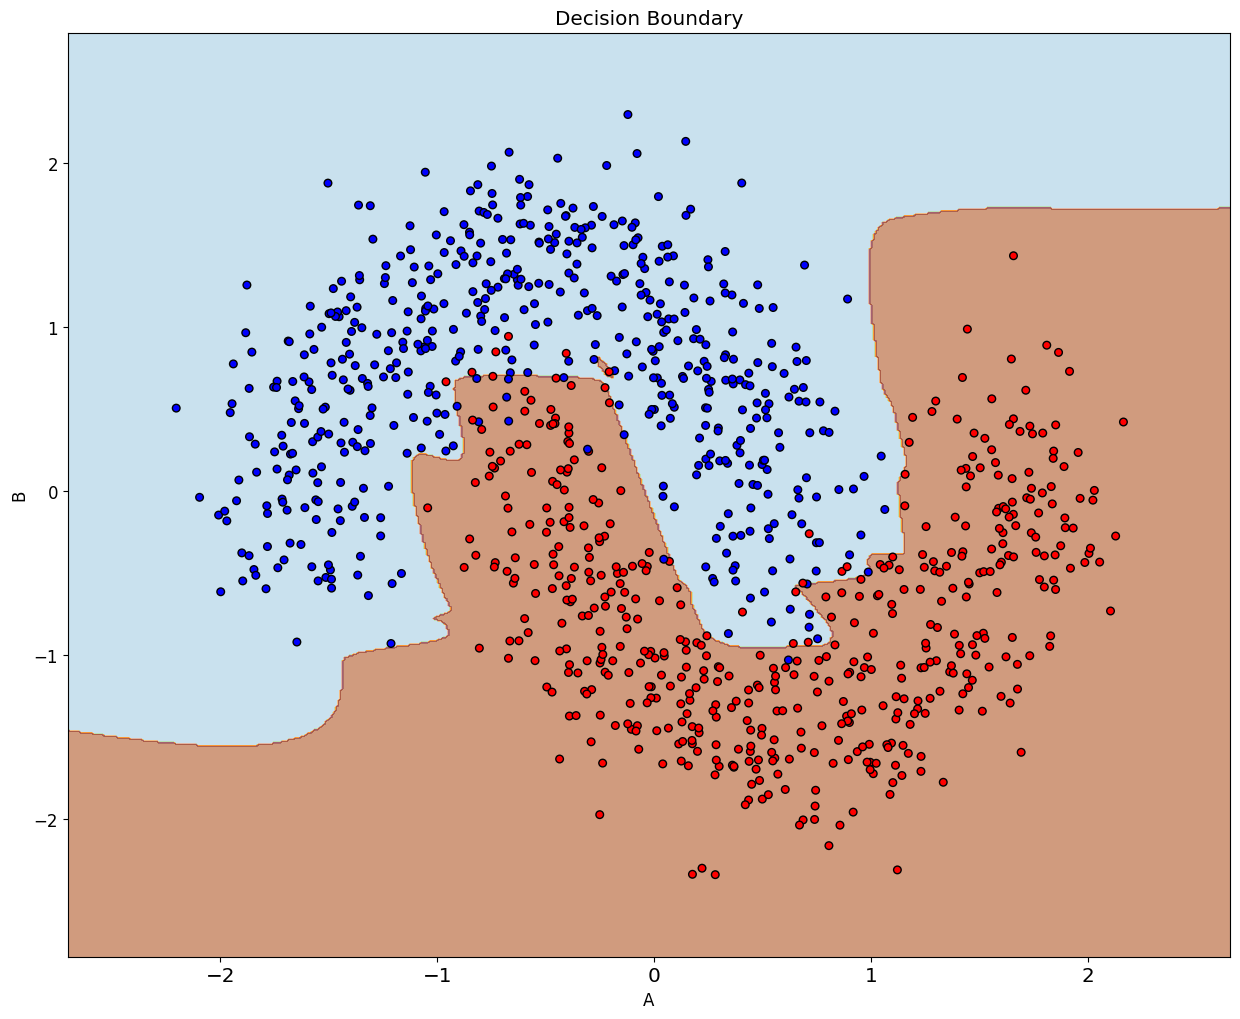

In [25]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)